In [1977]:
import numpy as np
import matplotlib.pyplot as plt
from typing import Callable, Tuple
from scipy.optimize import bisect, minimize_scalar

Метод золотого сечения

In [1978]:
def golden_ratio_method(
    f: Callable[[float], float], a: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    K = (np.sqrt(5) - 1) / 2
    x = b - (b - a) * K
    y = a + (b - a) * K
    
    fx, fy= f(x), f(y)
    
    for k in range(max_iter):
        if fx < fy:
            b = y
            y = x
            fy = fx
            x = b - (b - a) * K
            fx = f(x)
        else:
            a = x
            x = y
            fx = fy
            y = a + (b - a) * K
            fy = f(y)
        
        if (b - a) * K < epsilon:
            break
    
    return (x, fx) if fx < fy else (y, fy)

Метод парабол

In [1979]:
# Явная формула
def parabola_method(
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)

    for k in range(max_iter):
        u = c - ( (c - a)**2 * (f(c) - f(b)) - (c - b)**2 * (f(c) - f(a)) ) /  \
            ( 2 * ((c - a) * (f(c) - f(b)) - (c - b) * (f(c) - f(a))) )
        fu = f(u)

        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu
        
        if abs(b - a) < epsilon:
            break
    
    if fa <= fc and fa <= fb:
        return a, fa
    elif fc <= fa and fc <= fb:
        return c, fc
    else:
        return b, fb

# numpy.linalge.solve
def parabola_method_numpy   (
    f: Callable[[float], float], a: float, c: float, b: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    u = c
    fu = f(u)
    fa, fc, fb = f(a), f(c), f(b)
    
    for k in range(max_iter):
        try:
            A = np.array([
                [a**2, a, 1],
                [c**2, c, 1],
                [b**2, b, 1]
            ])
            a_coeff, b_coeff, _ = np.linalg.solve(A, np.array([fa, fc, fb]))
            u = -b_coeff / (2 * a_coeff)
        except np.linalg.LinAlgError:
            u = (a + b) / 2
        fu = f(u)
        
        if u < c:
            if fu < fc:
                b, fb = c, fc
                c, fc = u, fu
            elif fu > fc:
                a, fa = u, fu
        elif u > c:
            if fu < fc:
                a, fa = c, fc
                c, fc = u, fu
        else:
            b, fb = u, fu
        
        if abs(b - a) < epsilon:
            break
    
    if fa <= fc and fa <= fb:
        return a, fa
    elif fc <= fa and fc <= fb:
        return c, fc
    else:
        return b, fb

Метод Брента

In [1980]:
def brent_method(
    f: Callable[[float], float], a: float, c: float, epsilon: float = 1e-8, max_iter: int = 1000
) -> Tuple[float, float]:
    K = (3 - np.sqrt(5)) / 2
    x = w = v = (a + c) / 2
    fx = fw = fv = f(x)
    d = e = c - a

    for k in range(max_iter):
        u = None
        g = e
        e = d

        if len({x, w, v}) == 3 and len({fx, fw, fv}) == 3:
            u = x - ((x - v)**2 * (fx - fw) - (x - w)**2 * (fx - fv)) / \
                ( 2 * ((x - v) * (fx - fw) - (x - w) * (fx - fv)) )

        if u is not None and a + epsilon <= u <= c - epsilon and abs(u - x) < g / 2:
            d = abs(u - x)
        else:
            if x < (c + a) / 2:
                u = x + K * (c - x)
                d = c - x
            else:
                u = x - K * (x - a)
                d = x - a

        if abs(u - x) < epsilon:
            u = x + np.sign(u - x) * epsilon
            
        fu = f(u)

        if fu <= fx:
            if u >= x:
                a = x
            else:
                c = x
            v, w, x = w, x, u
            fv, fw, fx = fw, fx, fu
        else:
            if u >= x:
                c = u
            else:
                a = u
            if fu <= fw or w == x:
                v, w, fv, fw = w, u, fw,fu
            elif fu <= fv or v == x or v == w:
                v, fv = u, fu

        if abs(c - a) < 2 * epsilon or abs(fx - fw) < epsilon:
            break

    return x, fx

Исследуемые функции

In [1981]:
def f1(x: float):
    if x < -0.5 or x > 0.5:
        return np.inf
    return -5*x**5 + 4*x**4 - 12*x**3 + 11*x**2 - 2*x + 1

def f2(x: float):
    if x <= 2 or x >= 10:
        return np.inf  
    return -(np.log(x-2))**2 + (np.log(10-x))**2 - x**0.2

def f3(x: float):
    return -3*x * np.sin(0.75*x) + np.exp(-2*x)

def f4(x: float):
    return np.exp(3*x) + 5*np.exp(-2*x)

def f5(x: float):
    if x <= 0:
        return np.inf
    return 0.2*x * np.log(x) + (x-2.3)**2

Получение эталонных значений $x$, при которых функция на заданном отрезке минимальна

In [1982]:
intervals = [
    [-0.5, 0.5],
    [6, 9.9],
    [0, 2*np.pi],
    [0, 1],
    [0.5, 2.5]
]
derivatives = [
    lambda x: -25*x**4 + 16*x**3 - 36*x**2 + 22*x - 2,
    lambda x: -2*np.log(x - 2) / (x - 2) - 2*np.log(10 - x) / (10 - x) - 0.2*x**(-0.8),
    lambda x: -3*np.sin(0.75*x) - 2*np.exp(-2*x) - 2.25*x*np.cos(0.75*x),
    lambda x: 3*np.exp(3*x) - 10*np.exp(-2*x),
    lambda x: 0.2*np.log(x) + 0.2 + 2*(x - 2.3)
]
reference_points = []

for i, f in enumerate(derivatives):
    reference_points.append(round(bisect(f, a=intervals[i][0], b=intervals[i][1]), 12))
    print(f"f{i+1}: {reference_points[i]}")


f1: 0.109859915092
f2: 9.206243224292
f3: 2.706475581396
f4: 0.240794560867
f5: 2.124639773056


Применим оптимизацию

In [1983]:
functions = [f1, f2, f3, f4, f5]
errors_all = []
x_space = range(1, 121, 1)

for i, f in enumerate(functions):
    a, b = intervals[i]
    c = (a + b) / 2
    ref_x = reference_points[i]

    method_results = [
        [golden_ratio_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space],
        [parabola_method(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space],
        [parabola_method_numpy(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space],
        [brent_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space]
    ]

    method_errors = [ [abs(x_k - ref_x) for x_k in method_results[j]] for j in range(4) ]
    errors_all.append(method_errors)
    

Нарисуем графики

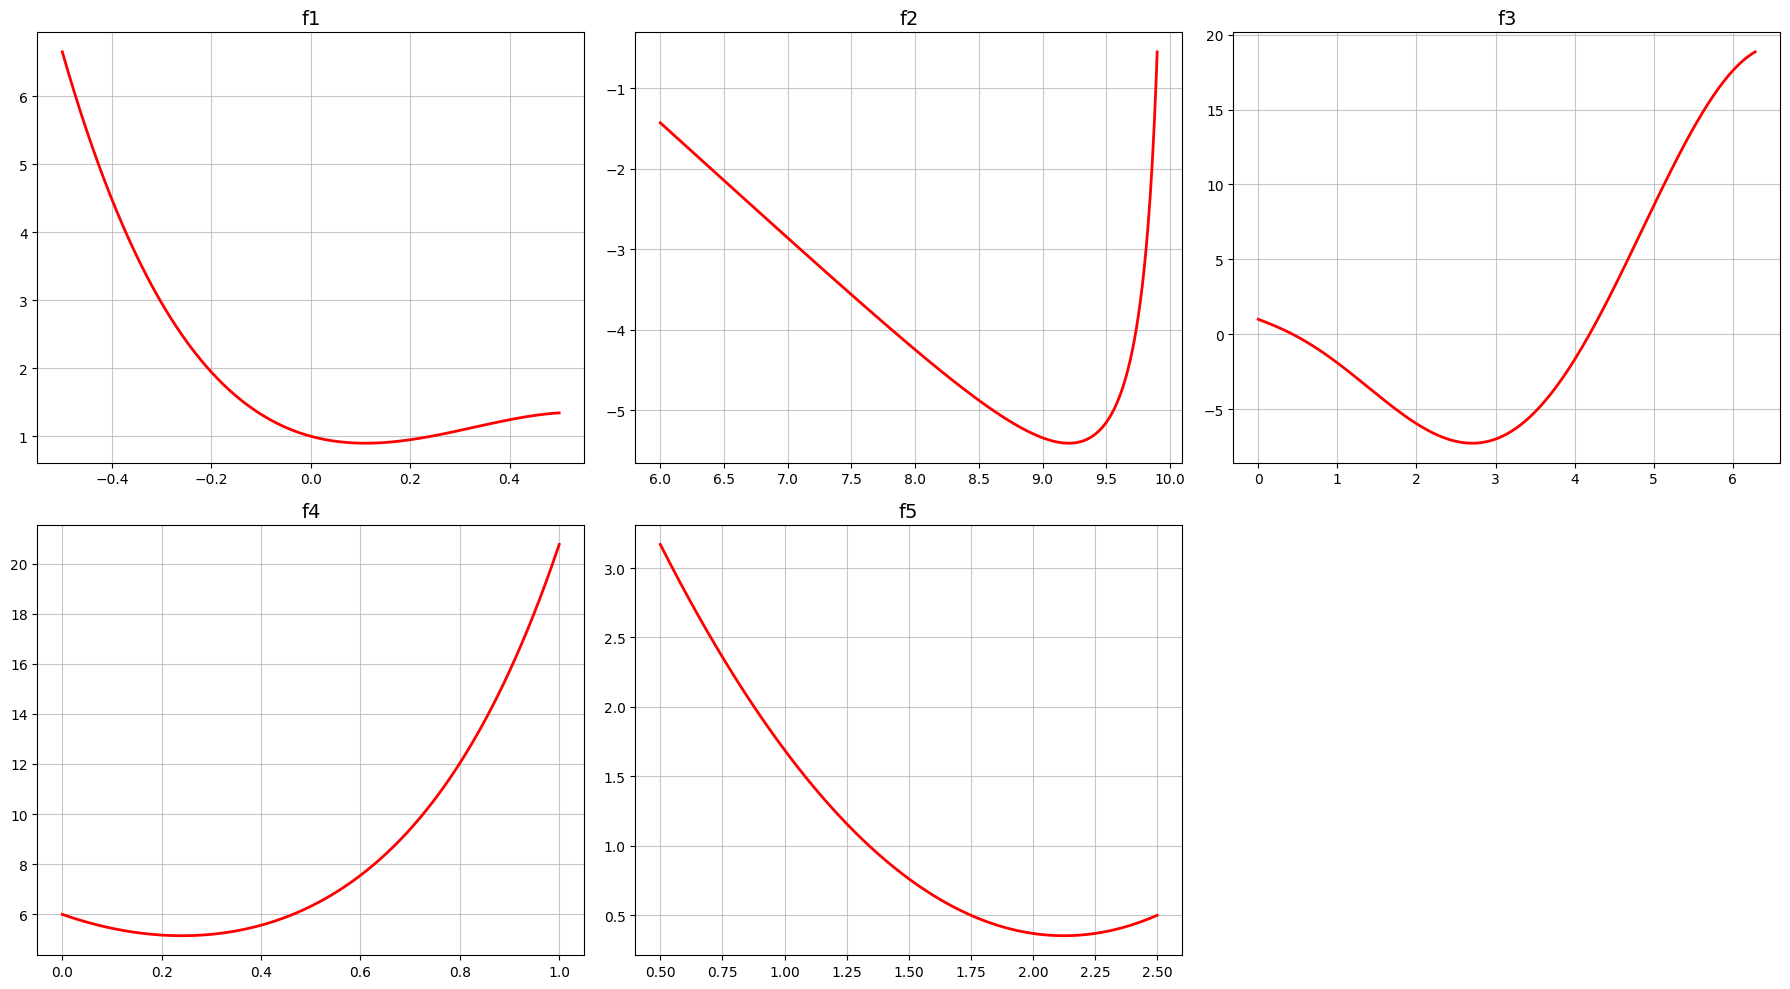

In [1984]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for i in range(5):
    x_array = np.linspace(intervals[i][0], intervals[i][1], 500)
    y = [functions[i](x) for x in x_array]
    axes[i // 3, i % 3].plot(x_array, y, color="red", linewidth=2)
    axes[i // 3, i % 3].set_title(f"f{i + 1}", fontsize=14)
    axes[i // 3, i % 3].grid(True, linestyle='-', alpha=0.7)

fig.delaxes(axes[1, 2])
plt.tight_layout()
plt.show()

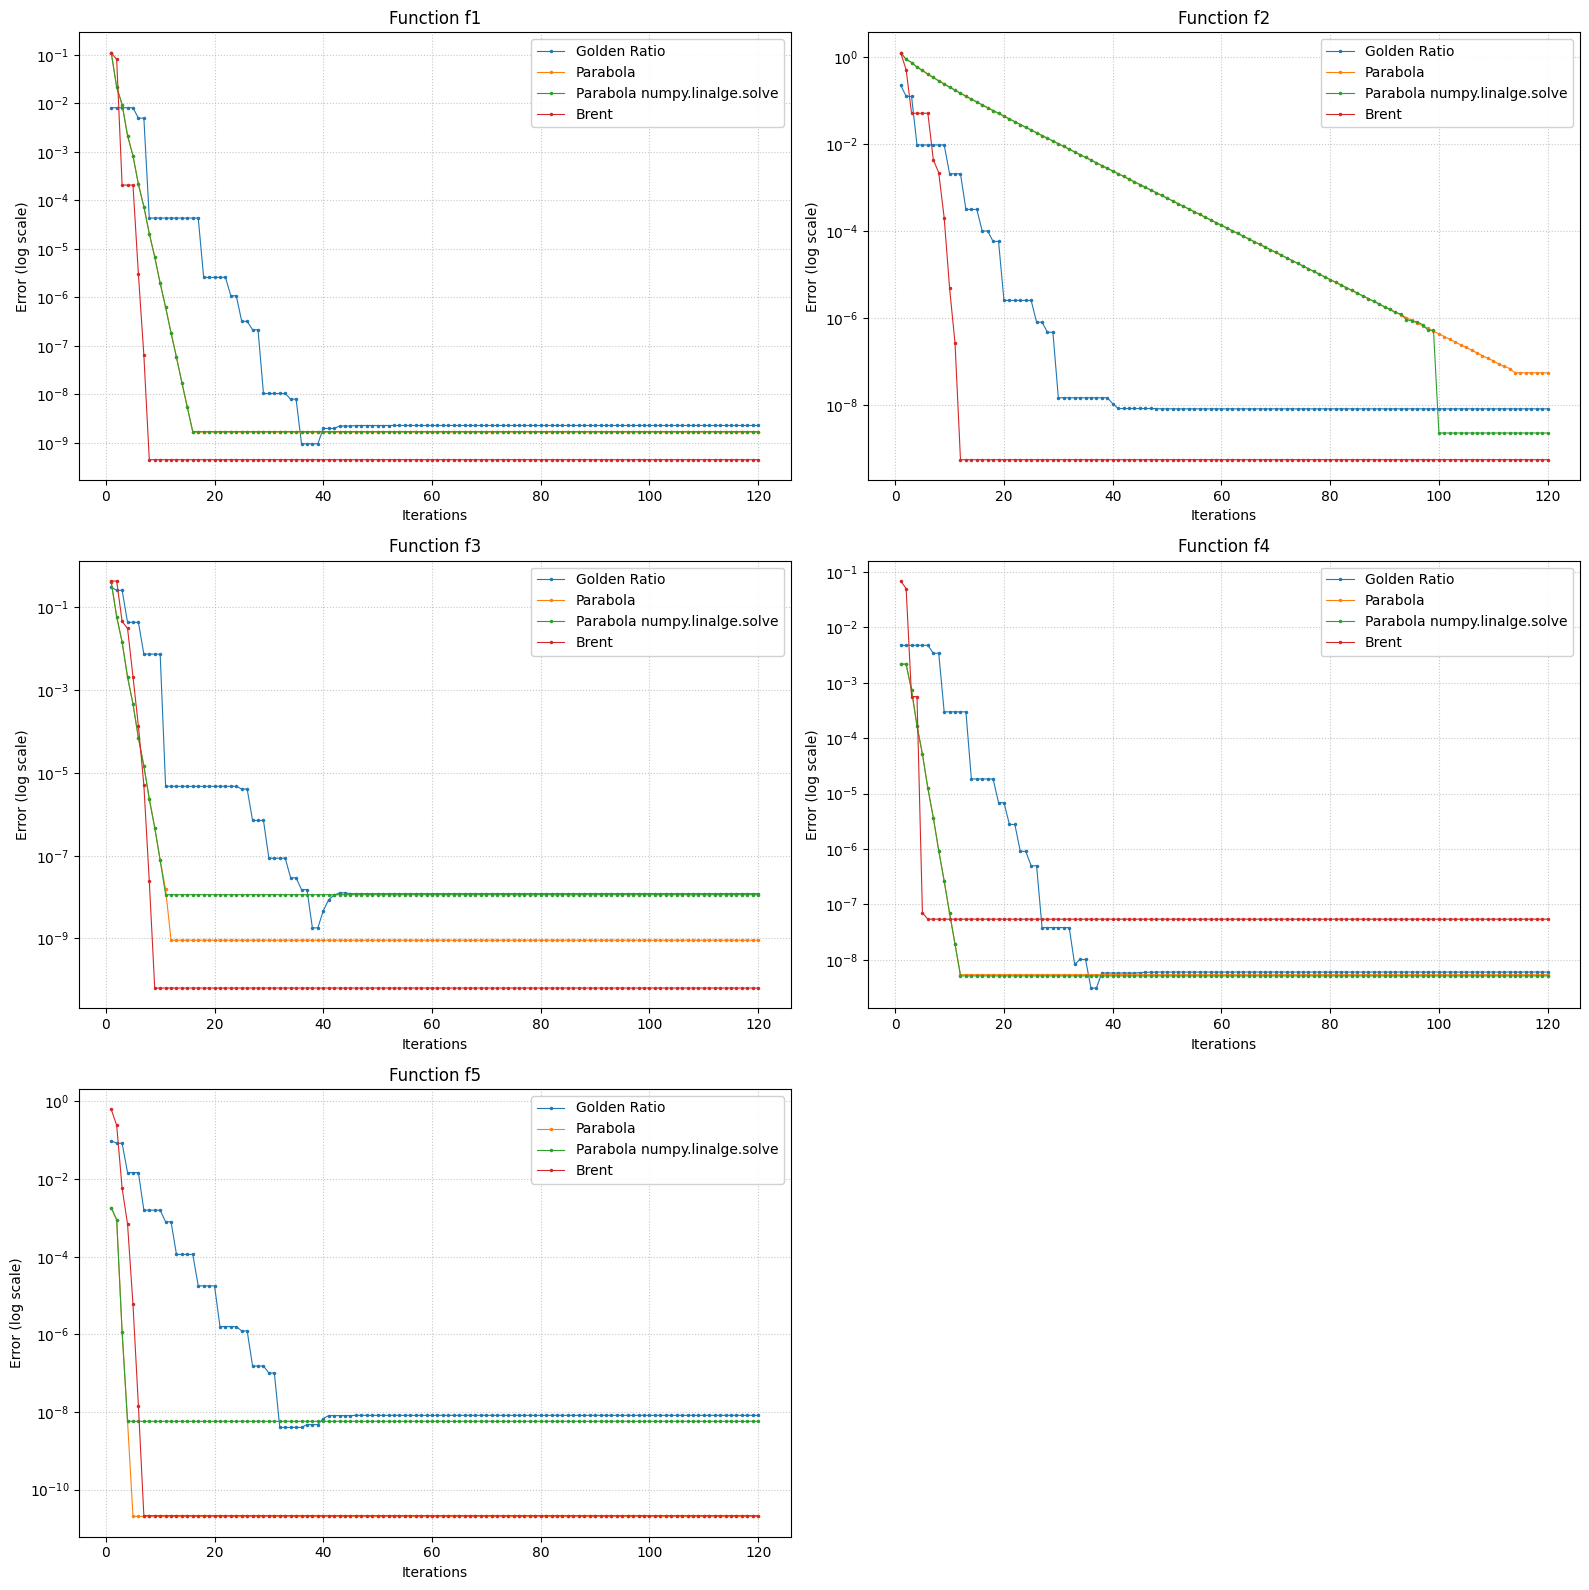

In [1985]:
method_names = ["Golden Ratio", "Parabola", "Parabola numpy.linalge.solve", "Brent"]

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)

for i in range(5):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0,-10,10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    for method_idx in range(4):
        method_name = method_names[method_idx]
        if errors_all[i][method_idx]:
            ax.plot(x_space, errors_all[i][method_idx],
                   label=method_name,
                   markersize=3,
                   marker=".",
                   linewidth=0.8)
    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)
    
fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

Оценим скорости сходимостей

In [1986]:
def estimate_convergence_order(errors):
    x = []
    y = []
    for i in range(1, len(errors)):
        x.append(np.log(abs(errors[i - 1])))
        y.append(np.log(abs(errors[i])))

    A = np.vstack([x, np.ones(len(x))]).T
    a, b = np.linalg.lstsq(A, y, rcond=None)[0]

    return a

def print_conv(errors_all, method_names, max_iter):
    for method_idx in range(len(method_names)): 
        print(f"Оценка порядка сходимости для метода {method_names[method_idx]}:")
        for i in range(len(errors_all)):
            p = estimate_convergence_order(errors_all[i][method_idx][:max_iter])
            print(f"f{i+1}: ≈ {p:.3f}")
        print("-" * 50)

In [1987]:
print_conv(errors_all, method_names, 20)

Оценка порядка сходимости для метода Golden Ratio:
f1: ≈ 0.918
f2: ≈ 1.010
f3: ≈ 0.903
f4: ≈ 0.975
f5: ≈ 0.938
--------------------------------------------------
Оценка порядка сходимости для метода Parabola:
f1: ≈ 0.943
f2: ≈ 0.965
f3: ≈ 0.905
f4: ≈ 0.922
f5: ≈ 0.740
--------------------------------------------------
Оценка порядка сходимости для метода Parabola numpy.linalge.solve:
f1: ≈ 0.943
f2: ≈ 0.965
f3: ≈ 0.885
f4: ≈ 0.923
f5: ≈ 0.660
--------------------------------------------------
Оценка порядка сходимости для метода Brent:
f1: ≈ 0.846
f2: ≈ 0.947
f3: ≈ 0.908
f4: ≈ 0.741
f5: ≈ 0.847
--------------------------------------------------


Из графиков и расчётов видно, что золотое сечение - самый стабильный, или же, предсказуемый метод. Парабола в основном имеет более быструю сходимость,но зависит от функции. Парабола с `numpy.linalge.solve` ведёт себя так же, но в некоторых функциях в результате отстает, либо, наоборот, при большом количестве итераций, добивается большей точности, по сравнению с явной формулой для параболы. Метод Брента является явным победителем по скорости на маленьком количестве итераций.
Скорости сходимости:
 - Метод золотого сечения - линейная
 - Метод парабол - суперлинейная
 - Метод парабол с `numpy.linalge.solve` - суперлинейная
 - Метод Брента - суперлинейная либо линейная, в зависимости от функции


#### Используем `scipy.optimize.minimize_scalar`:

In [1988]:
errors_all_scipy = []
x_space_scipy = range(1, 61, 1)

for i, f in enumerate(functions):
    a, b = intervals[i]
    c = (a + b) / 2
    ref_x = reference_points[i]

    method_results = [
        [minimize_scalar(f, method='golden', bracket=(a, b), tol=1e-12, options={'maxiter': x}).x for x in x_space_scipy],
        [minimize_scalar(f, method='bounded', bounds=(a, b), options={'maxiter': x}).x for x in x_space_scipy],
        [minimize_scalar(f, method='brent', bracket=(a, b), tol=1e-12, options={'maxiter': x}).x for x in x_space_scipy]
    ]

    method_errors = [ [abs(x_k - ref_x) for x_k in method_results[j]] for j in range(3) ]
    errors_all_scipy.append(method_errors)
    

/home/ns/Desktop/OptMeth/.venv/lib/python3.12/site-packages/scipy/optimize/_optimize.py:2502: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)


Построим графики:

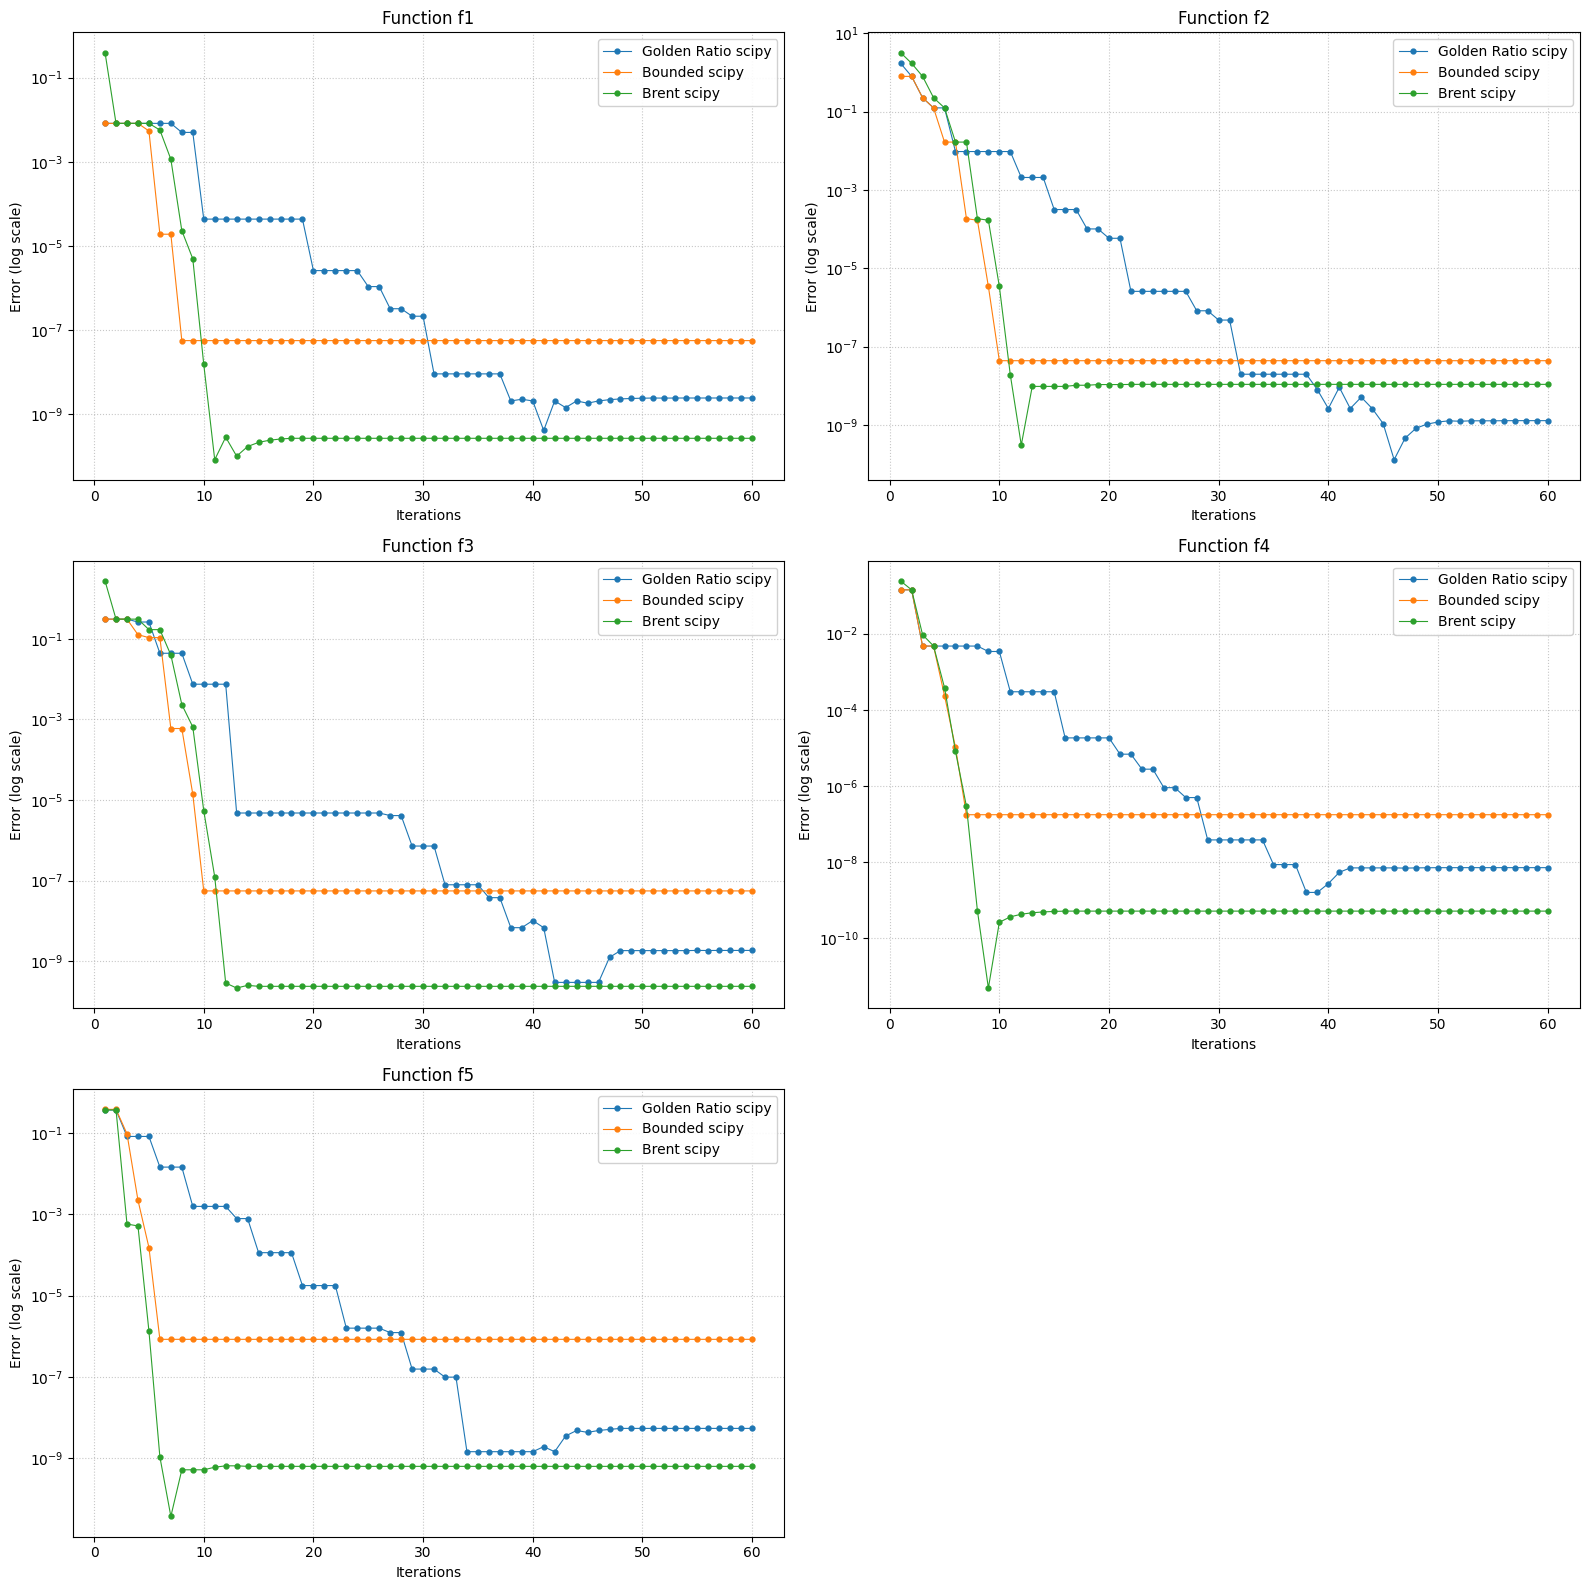

In [1989]:
method_names_scipy = ["Golden Ratio scipy", "Bounded scipy", "Brent scipy"]

fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)

for i in range(5):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0, -11, 10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    for method_idx in range(3):
        method_name = method_names_scipy[method_idx]
        if errors_all_scipy[i][method_idx]:
            ax.plot(x_space_scipy, errors_all_scipy[i][method_idx], 
                   label=method_name,
                   markersize=7,
                   marker=".",
                   linewidth=0.8)
    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)
 
fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

Оценим скорости сходимостей

In [1990]:
print_conv(errors_all_scipy, method_names_scipy, 40)

Оценка порядка сходимости для метода Golden Ratio scipy:
f1: ≈ 0.983
f2: ≈ 0.977
f3: ≈ 0.958
f4: ≈ 0.970
f5: ≈ 0.980
--------------------------------------------------
Оценка порядка сходимости для метода Bounded scipy:
f1: ≈ 0.871
f2: ≈ 0.897
f3: ≈ 0.909
f4: ≈ 0.829
f5: ≈ 0.813
--------------------------------------------------
Оценка порядка сходимости для метода Brent scipy:
f1: ≈ 0.896
f2: ≈ 0.903
f3: ≈ 0.927
f4: ≈ 0.852
f5: ≈ 0.786
--------------------------------------------------


В данном пакете нет метода параболы, в остальном, наблюдаем примерно такую же картину.

#### Теперь сравним наши методы с аналогичными из scipy

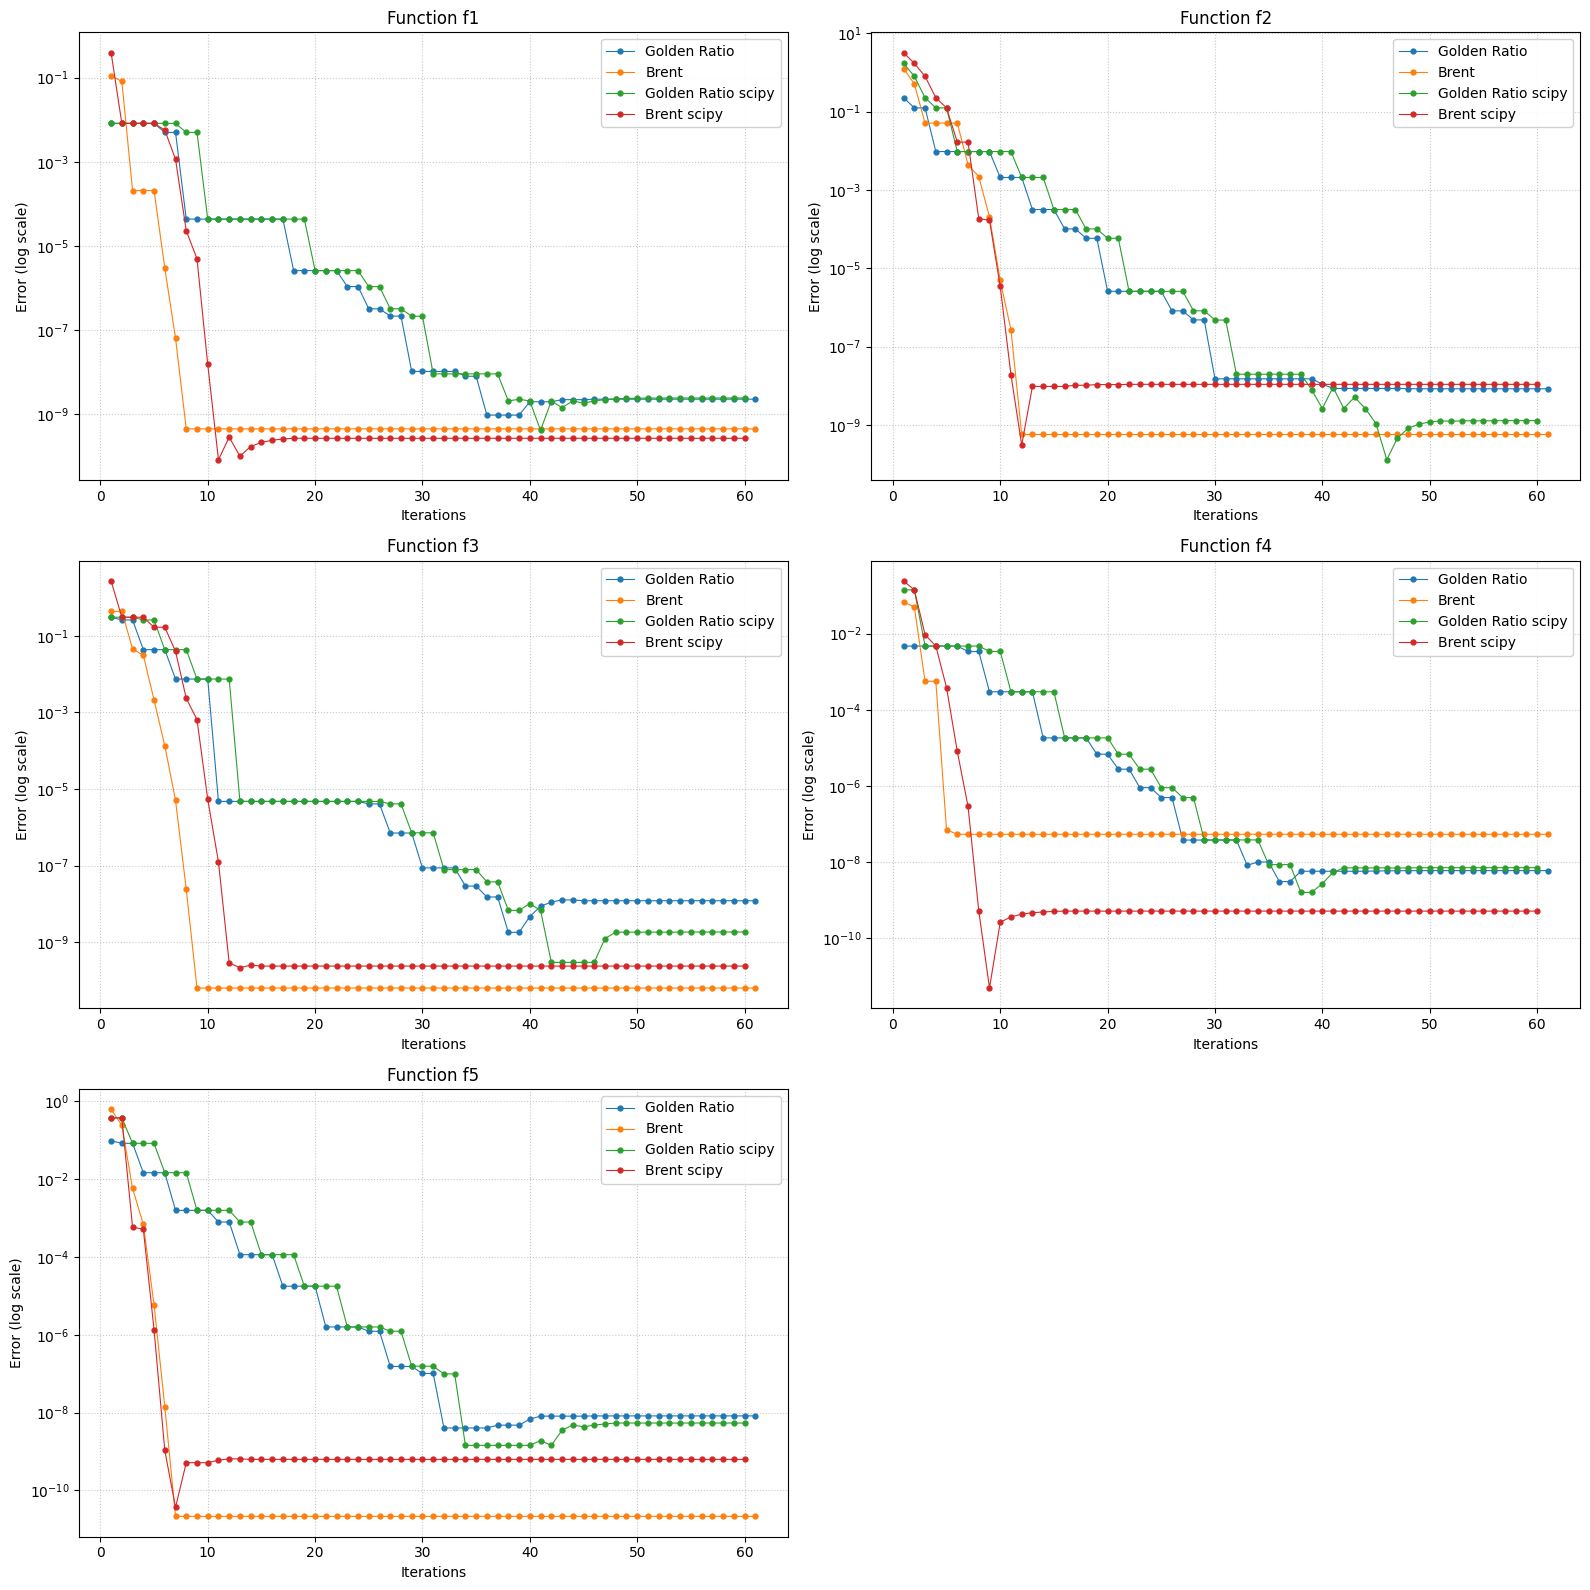

In [1991]:
fig, axes = plt.subplots(3, 2, figsize=(16, 16))
fig.subplots_adjust(hspace=0.5)

for i in range(5):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0,-10,10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)

    for method_idx in (0, 3):
        method_name = method_names[method_idx]
        if errors_all[i][method_idx]:
            ax.plot(x_space[:61], errors_all[i][method_idx][:61], 
                   label=method_name,
                   markersize=7,
                   marker=".",
                   linewidth=0.8)
    for method_idx in (0,2):
        method_name = method_names_scipy[method_idx]
        if errors_all_scipy[i][method_idx]:
            ax.plot(x_space[:60], errors_all_scipy[i][method_idx][:60], 
                   label=method_name,
                   markersize=7,
                   marker=".",
                   linewidth=0.8)
            
    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)
    
fig.delaxes(axes[2, 1])
plt.tight_layout()
plt.show()

По графикам видно, что методы получились близки друг к другу, разве что, наш метод Брента подвисает на 4-й функции.
##### Теперь выберем 3 мультмодальные фунции и протестируем методы на них
Брать "хорошие" для анализа функции, может быть, и приятно, но полезнее и интереснее будет рассмотреть такие, на которых наши методы начнут ломаться. Поэтому возьмём функции: не сильно "выраженную" мултимодальную и с точкой минимума близкой к границе, сильно осцилирующую и с точкой минимума еще ближе к границе и средне-осцилирующую с точкой близко к центру.

In [1992]:
def mm1(x):
    return (x-2)**2 * (x+1)**2 - x
def mm2(x):
    return np.exp(0.5*x) * np.sin(4*x)
def mm3(x):
    return -np.cos(4*x - 0.2)*np.cos(6*x - 0.2)

mm_functions = [mm1, mm2, mm3]
mm_intervals = [
    [-1.1, 2.5],
    [-1, 6],
    [-0.8, 0.8]
]

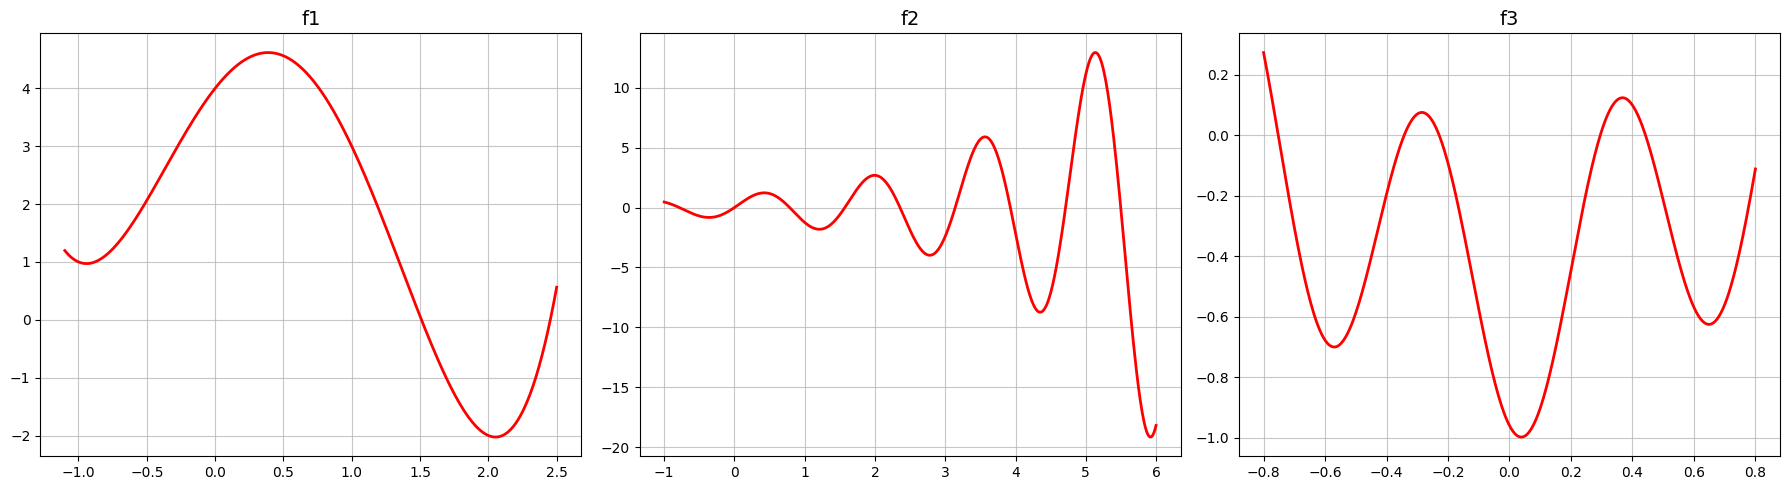

In [1993]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for i in range(3):
    x_array = np.linspace(mm_intervals[i][0], mm_intervals[i][1], 500)
    y = [mm_functions[i](x) for x in x_array]
    axes[i].plot(x_array, y, color="red", linewidth=2)
    axes[i].set_title(f"f{i + 1}", fontsize=14)
    axes[i].grid(True, linestyle='-', alpha=0.7)

plt.tight_layout()
plt.show()

Получение эталонных значений $x$, при которых функция на заданном отрезке минимальна

In [1994]:
mm_intervals_for_dd = [
    [0.5, 2.5],
    [5, 7],
    [-0.22, 0.24]
]
derivatives_mm = [
    lambda x: 4*x**3 - 6*x**2 - 6*x + 3,
    lambda x: np.exp(0.5*x)*(np.sin(4*x)*0.5 + 4*np.cos(4*x)),
    lambda x: 4*(np.sin(4*x - 0.2)*np.cos(6*x - 0.2) + 1.5*np.sin(6*x - 0.2)*np.cos(4*x - 0.2))
]
reference_points_mm = []

for i, f in enumerate(derivatives_mm):
    reference_points_mm.append(round(bisect(f, a=mm_intervals_for_dd[i][0], b=mm_intervals_for_dd[i][1]), 12))
    print(f"f{i+1}: {reference_points_mm[i]}")

f1: 2.052741308262
f2: 6.706973137514
f3: 0.038462938859


In [1995]:
errors_all_mm = []
x_space_mm = range(1, 61, 1)

for i, f in enumerate(mm_functions):
    a, b = mm_intervals[i]
    c = b - 0.01
    ref_x = reference_points_mm[i]

    method_results = [
        [golden_ratio_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm],
        [parabola_method(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm],
        [parabola_method_numpy(f, a, c, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm],
        [brent_method(f, a, b, max_iter=x, epsilon=1e-12)[0] for x in x_space_mm]
    ]

    method_errors = [ [abs(x_k - ref_x) for x_k in method_results[j]] for j in range(4) ]
    errors_all_mm.append(method_errors)


Построим графики

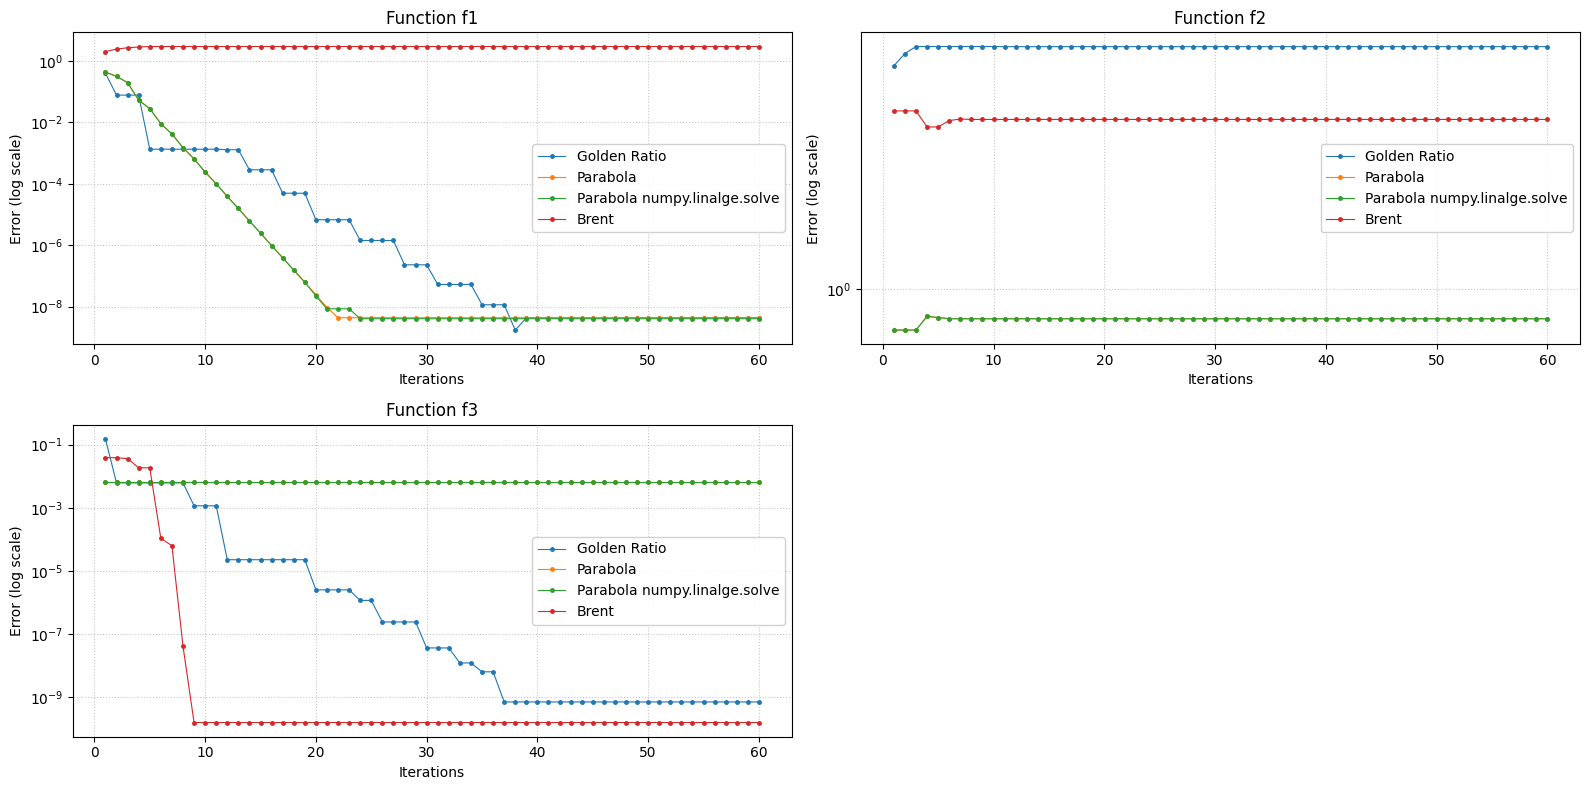

In [1996]:
fig, axes = plt.subplots(2, 2, figsize=(16, 8))
fig.subplots_adjust(hspace=0.5)

for i in range(3):
    ax = axes[i // 2, i % 2]
    ax.set_title(f'Function f{i+1}', fontsize=12)
    ax.set_xlabel('Iterations', fontsize=10)
    ax.set_ylabel('Error (log scale)', fontsize=10)
    ax.set_yticks(np.logspace(0,-10,10))
    ax.set_yscale('log')
    ax.grid(True, which='both', linestyle=':', alpha=0.7)
    for method_idx in range(4):
        method_name = method_names[method_idx]
        if errors_all_mm[i][method_idx]:
            ax.plot(x_space_mm, errors_all_mm[i][method_idx],
                   label=method_name,
                   markersize=5,
                   marker=".",
                   linewidth=0.8)
    ax.minorticks_off()
    ax.legend(fontsize=10, framealpha=0.9)
    
fig.delaxes(axes[1, 1])
plt.tight_layout()
plt.show()

Оценим скорости сходимостей

In [1997]:
print_conv(errors_all_mm, method_names, 40)

Оценка порядка сходимости для метода Golden Ratio:
f1: ≈ 0.962
f2: ≈ 0.320
f3: ≈ 0.967
--------------------------------------------------
Оценка порядка сходимости для метода Parabola:
f1: ≈ 0.951
f2: ≈ 0.590
f3: ≈ 0.962
--------------------------------------------------
Оценка порядка сходимости для метода Parabola numpy.linalge.solve:
f1: ≈ 0.951
f2: ≈ 0.590
f3: ≈ 0.962
--------------------------------------------------
Оценка порядка сходимости для метода Brent:
f1: ≈ 0.495
f2: ≈ 0.441
f3: ≈ 0.899
--------------------------------------------------


Самое примечательно - с осциляцией не справился никто ($f_2$). Это произошло, потому что на первых итерациях алгоритмы не могут найти хорошую точку, так как постоянно перескакивают с одной "горки" фукнции на другую. Первую функцию смогли побороть метод золотого сечения и методы парабол, метод Брента запутался и выбрал неверную стратегию на первых же ходах, из-за чего ушёл совсем мимо. В третьей функции, напротив, метод Брента вместе с золотым сечением смог найти хорошее приближение (учитывая то, как работает алгоритм - верная стратегия тут, по всей видимости, оказалась выбирать золотое сечение при первом приближении, и после нескольких шагов переключиться на параболу и эффективно "добить" цель в пару итераций).